In [11]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

from tf_lab.fundamentals.utils import set_visible_GPUs, reset_tf_graph

import tf_lab.point_clouds.in_out as pio
from tf_lab.point_clouds.in_out import PointCloudDataSet, write_model_ids_of_datasets
from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf
import tf_lab.point_clouds.encoders_decoders as enc_dec


from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id, match_incomplete_to_complete_data
import tf_lab.autopredictors.scripts.virt_scan_data as vscan

from tf_lab.autopredictors.plotting import plot_original_pclouds_vs_reconstructed, \
                                           plot_train_val_test_curves, plot_reconstructions_at_epoch, \
                                           plot_interpolations
from tf_lab.autopredictors.evaluate import eval_model, read_saved_epochs, accuracy_of_completion, \
                                           coverage_of_completion
                                                  


from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs
from general_tools.simpletons import select_first_last_and_k
from geo_tool import Point_Cloud

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
n_points = 2048

experiment_name = '4_virt_scan_emd_2fc_decoder_' + str(n_points) + 'pts'

do_training = False
do_plotting = False
first_time_running = False
load_model = True

class_type = raw_input('Give me the class type.\n').lower()
class_syn_id = shape_net_category_to_synth_id()[class_type]

Give me the class type.
chair


In [4]:
seed = 42
np.random.seed(seed)
tf.set_random_seed(seed)

top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'
full_pclouds_path = osp.join(top_data_dir, 'ShapeNetPointClouds/from_manifold_meshes/', str(n_points), class_syn_id)

train_dir = osp.join(top_data_dir, 'OUT/models/incomplete_pclouds/')
train_dir = osp.join(train_dir, experiment_name)
create_dir(train_dir)

'/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/4_virt_scan_emd_2fc_decoder_2048pts'

In [5]:
full_file_names = pio.load_filenames_of_input_data(full_pclouds_path)
full_pclouds, full_model_names, class_ids = pio.load_crude_point_clouds(file_names=full_file_names, n_threads=20)
print '%d files containing complete point clouds were found.' % (len(full_pclouds), )

    
v_scan_top_dir = osp.join(top_data_dir, 'From_Matthias/shapenet_dim32_sdf_pc', class_syn_id)    
search_pattern = '.ply'

if do_training:
    train_id_file = '/orions4-zfs/projects/lins2/Panos_Space/DATA/From_Matthias/shapenet_all-train.txt'
    train_data = vscan.load_single_class_incomplete_dataset(v_scan_top_dir, train_id_file, class_syn_id, 
                                                      full_pclouds, full_model_names, n_threads = 24,
                                                      n_samples=n_points, search_pattern=search_pattern)
else:
    test_id_file = '/orions4-zfs/projects/lins2/Panos_Space/DATA/From_Matthias/shapenet_all-test.txt'
    test_data = vscan.load_single_class_incomplete_dataset(v_scan_top_dir, test_id_file, class_syn_id, 
                                                      full_pclouds, full_model_names, n_threads=24,
                                                      n_samples=n_points, search_pattern=search_pattern)


6778 files containing complete point clouds were found.
8000 incomplete point clouds were loaded.


In [6]:
if load_model:
    conf = Conf.load(osp.join(train_dir, 'configuration'))
    print conf
else:
    n_input = [n_points, 3]    
    decoder_args = {'layer_sizes': [1024, np.prod(n_input)], 
                    'non_linearity': tf.nn.relu
                   }

    conf = Conf(
                n_input = n_input,
                denoising = True,
                training_epochs = 400,
                batch_size = 50,
                loss = 'emd',
                train_dir = train_dir,
                loss_display_step = 1,
                saver_step = 10,
                learning_rate = 0.00002,
                gauss_augment = {'mu': 0, 'sigma': 0.01},
                encoder = enc_dec.encoder_with_convs_and_symmetry,
                decoder = enc_dec.decoder_with_fc_only,
                decoder_args = decoder_args,
               )

    conf.experiment_name = experiment_name
    conf.save(osp.join(conf.train_dir, 'configuration'))

                    batch_size: 50
                         debug: False
                       decoder: decoder_with_fc_only
                  decoder_args: {'non_linearity': <function relu at 0x7f8d65f6ef50>, 'layer_sizes': [1024, 6144]}
                       encoder: encoder_with_convs_and_symmetry
                  encoder_args: {}
               experiment_name: 4_virt_scan_chamfer_2fc_decoder_2048pts
                 gauss_augment: {'mu': 0, 'sigma': 0.01}
                  is_denoising: True
               latent_vs_recon: 1.0
                 learning_rate: 2e-05
                          loss: emd
             loss_display_step: 1
                       n_input: [2048, 3]
                           n_z: None
             saver_max_to_keep: None
                    saver_step: 10
                     train_dir: /orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/4_virt_scan_emd_2fc_decoder_2048pts
               training_epochs: 400
                     

In [7]:
reset_tf_graph()
set_visible_GPUs([1])
ae = PointNetAutoEncoder(conf.experiment_name, conf)

if do_training:
    ae.train(train_data, conf)

else:
    saved_epochs = read_saved_epochs(conf.train_dir)
    ae.restore_model(conf.train_dir, saved_epochs[-1])

In [44]:
if do_plotting:
    saved_epochs = read_saved_epochs(conf.train_dir)
    plot_epochs = select_first_last_and_k(saved_epochs, 13)
    stats = eval_model(ae, conf, [train_data, test_data], epochs=plot_epochs)
    top_save_dir = osp.join(conf.train_dir, 'model_evaluation')
    plot_train_val_test_curves(stats, top_save_dir, has_validation=False, best_epoch=None, show=True)
    last_epoch = saved_epochs[-1]
    save_dir = osp.join(top_save_dir, 'train_images_epoch_' + str(last_epoch))
    plot_reconstructions_at_epoch(last_epoch, ae, train_data, conf, save_dir=save_dir, max_plot=100)    
    save_dir = osp.join(top_save_dir, 'test_images_epoch_' + str(last_epoch))
    plot_reconstructions_at_epoch(last_epoch, ae, test_data, conf, save_dir=save_dir, max_plot=100)

250

In [9]:
conf.batch_size = 100
reconstructions, losses, feed_data, ids, original_data = ae.evaluate(test_data, conf)

In [18]:
n_examples = len(reconstructions)
pred_scores = np.zeros((n_examples, 2))
bline_scores = np.zeros((n_examples, 2))

for i in xrange(400):
    full_gt = original_data[i]
    pred = reconstructions[i]

    bline_scores[i, 0], _ = accuracy_of_completion(feed_data[i], full_gt, thres=0.01, ret_dists=False)
    bline_scores[i, 1], _ = coverage_of_completion(full_gt, feed_data[i], thres=0.01, ret_dists=False)

#     pred_scores[i, 0], _ = accuracy_of_completion(pred, full_gt, thres=0.02, ret_dists=False)
#     pred_scores[i, 1], _ = coverage_of_completion(full_gt, pred, thres=0.02, ret_dists=False)

#     print pred_scores[i, 0], pred_scores[i, 1]
    
    pred = Point_Cloud(points=pred).center_in_unit_sphere().points
    pred_scores[i, 0], _ = accuracy_of_completion(pred, full_gt, thres=0.01, ret_dists=False)
    pred_scores[i, 1], _ = coverage_of_completion(full_gt, pred, thres=0.01, ret_dists=False)
#     print pred_scores[i, 0], pred_scores[i, 1]

0.99365234375


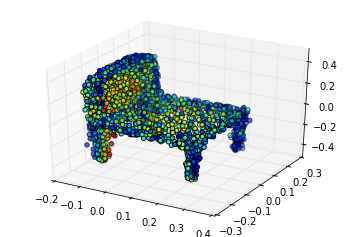

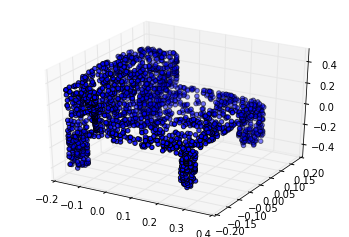

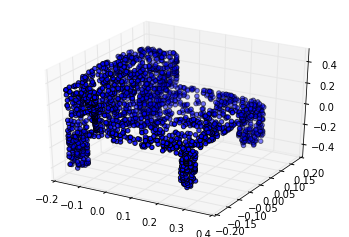

In [37]:
i = 7
full_gt = original_data[i]
pred = reconstructions[i]

s, c = accuracy_of_completion(pred, full_gt, thres=0.05, ret_dists=True)
print s
Point_Cloud(points=pred).plot(c=c)

Point_Cloud(points=full_gt).plot()



In [19]:
print np.mean(bline_scores[:400,0]), np.mean(bline_scores[:400,1])
print np.mean(pred_scores[:400,0]), np.mean(pred_scores[:400,1])

0.110194091797 0.115606689453
0.153986816406 0.165786132812


In [14]:
print np.mean(bline_scores[:,0]), np.mean(bline_scores[:,1])
print np.mean(pred_scores[:,0]), np.mean(pred_scores[:,1])

0.423091796875 0.397195068359
0.56194342041 0.579235961914
